载入特征文件（）并建立网络，分类，进行训练，

In [1]:
import h5py
import numpy as np
from sklearn.utils import shuffle
import os
import cv2
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
train_features = []
test_features = []
train_labels = []
train_files = []

train_files_temp = []
with h5py.File("modelfile/xception_bottleneck.h5", 'r') as h:
    train_features.append(np.array(h['train_features']))
    test_features.append(np.array(h['test_features']))
    train_labels.append(np.array(h['train_label']))
    train_files_temp.append(np.array(h['train_file_que']))

In [3]:
train_features = train_features[0]
test_features = test_features[0]
train_labels = train_labels[0]
for file in train_files_temp[0]:
    train_files.append(file.decode())

In [4]:
#验证数据集的形状是否正确
print("train_features shape:",np.shape(train_features))
print("test_features shape:",np.shape(test_features))
print("train_labels shape:",np.shape(train_labels))
print("train_files shape:",np.shape(train_files))
print("train_features data type:",train_features.dtype)

train_features shape: (37399, 2048)
test_features shape: (12500, 2048)
train_labels shape: (37399,)
train_files shape: (37399,)
train_features data type: float32


In [5]:
#是否打乱
train_features, train_labels,train_files = shuffle(train_features, train_labels,train_files)

构建网络

In [6]:
from keras.layers import Input, Dropout, Dense
from keras.models import Model
from keras import optimizers
from keras.callbacks import TensorBoard

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
inputlayer = Input(shape=(train_features.shape[1:]))

In [8]:
x = inputlayer

x = Dropout(0.8,seed=0)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.8,seed = 0)(x)
outlayer = Dense(1, kernel_initializer="glorot_uniform", activation='sigmoid')(x)

model = Model(inputs=inputlayer, outputs=outlayer)

In [9]:
#优化器参考：https://keras.io/optimizers/
# Stochastic gradient descent optimizer.
opt = optimizers.SGD(lr=0.003, momentum=0.8)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(train_features,train_labels,epochs=50,verbose=1,validation_split=0.2, batch_size=128, callbacks=[TensorBoard(log_dir='./log')])
model.save('modelfile/model.h5')

Train on 29919 samples, validate on 7480 samples
Epoch 1/50
29919/29919 [==============================] - 1s 45us/step - loss: 0.3667 - acc: 0.8373 - val_loss: 0.0946 - val_acc: 0.9905
Epoch 2/50
29919/29919 [==============================] - 1s 40us/step - loss: 0.1488 - acc: 0.9540 - val_loss: 0.0484 - val_acc: 0.9912
Epoch 3/50
29919/29919 [==============================] - 1s 40us/step - loss: 0.1055 - acc: 0.9667 - val_loss: 0.0378 - val_acc: 0.9916
Epoch 4/50
29919/29919 [==============================] - 1s 40us/step - loss: 0.0896 - acc: 0.9721 - val_loss: 0.0324 - val_acc: 0.9918
Epoch 5/50
29919/29919 [==============================] - 1s 39us/step - loss: 0.0825 - acc: 0.9742 - val_loss: 0.0310 - val_acc: 0.9912
Epoch 6/50
29919/29919 [==============================] - 1s 39us/step - loss: 0.0779 - acc: 0.9761 - val_loss: 0.0299 - val_acc: 0.9912
Epoch 7/50
29919/29919 [==============================] - 1s 39us/step - loss: 0.0698 - acc: 0.9783 - val_loss: 0.0275 - val_acc:

In [10]:
# 都预测为0.5的情况下，loss = 0.69314
pred = model.predict(train_features, batch_size=None, verbose=0, steps=None)

预测并打印对比真实标签和预测值

In [11]:
label = list(map(lambda x: "%.3f"%float(x), train_labels[:10]))
pred_p = list(map(lambda x: "%.3f"%float(x), pred.flatten()[:10]))
print("  label:",label)
print("predict:",pred_p)

  label: ['1.000', '0.000', '1.000', '0.000', '0.000', '1.000', '1.000', '0.000', '0.000', '0.000']
predict: ['0.999', '0.000', '0.999', '0.000', '0.000', '0.996', '0.995', '0.000', '0.000', '0.000']


此处可以打印10张图片，验证是否正确

In [12]:
file_names = []
for i,file in enumerate(train_files[:10]):
    file = os.path.join("processed_train_data",file)
    fname = os.path.split(file)[1]
    file_names.append(fname)
print(file_names)

['dog.10663.jpg', 'cat.717.jpg', 'dog.1600.jpg', 'cat.11210_chbright.jpg', 'cat.2746.jpg', 'dog.7967_origin.jpg', 'dog.12018.jpg', 'cat.4143.jpg', 'cat.3576_lrotate.jpg', 'cat.8140.jpg']


In [13]:
def showimgs(imgs,titles=None):
    plt.subplot(1,2,1)
    plt.imshow(imgs[0])
    plt.title(titles[0])
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(imgs[1])
    plt.title(titles[1])
    plt.axis('off')
    plt.show()

打印训练图片的前10张，对比预测和图片

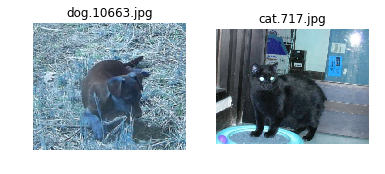

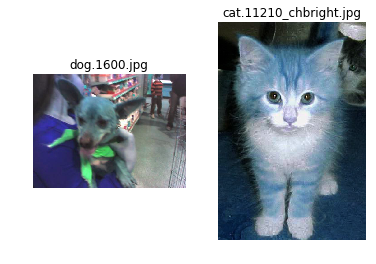

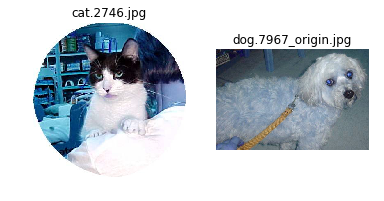

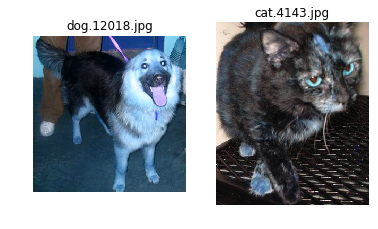

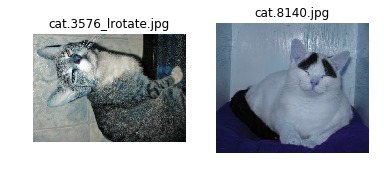

In [14]:
train_imgs = []
train_file_names = []
for i,file in enumerate(train_files[:10]):
    file = os.path.join("processed_train_data",file)
    file_name = os.path.split(file)[1]
    img = cv2.imread(file)
    #print(i)
    train_imgs.append(img)
    train_file_names.append(file_name)
#
train_imgs = np.array(train_imgs).reshape(5,2)
train_file_names = np.array(train_file_names).reshape(5,2)
for i, imgs in enumerate(train_imgs):
    showimgs(imgs,train_file_names[i])